In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import nawrapper as nw
import nawrapper.maputils as maputils

import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

Let's generate a random map to try doing analysis on.

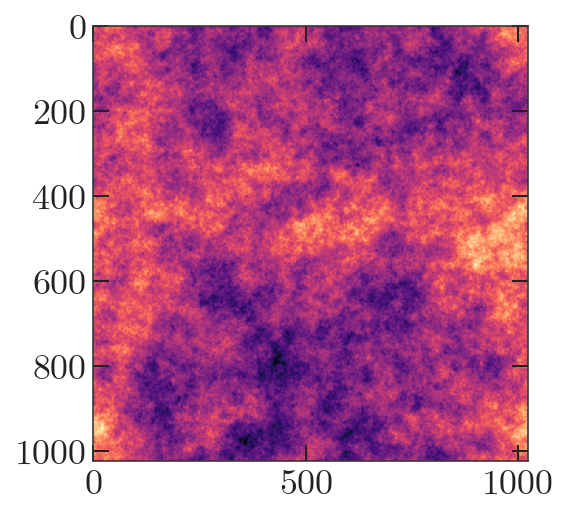

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

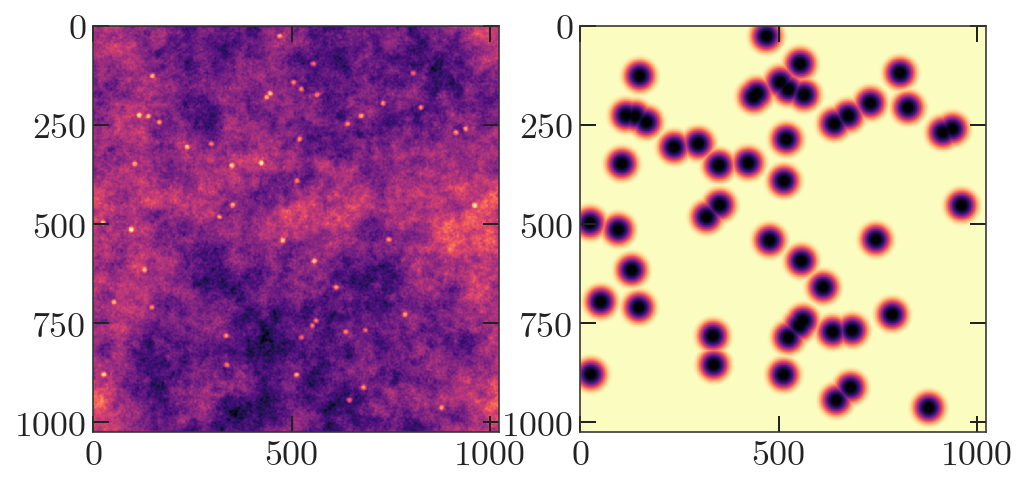

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-maputils.apod_C2(mask, 0.1)
imap += point_source_map
mask = maputils.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8,16))

axes[0].imshow(imap)
axes[1].imshow(mask)

Now let's do two noise realizations.

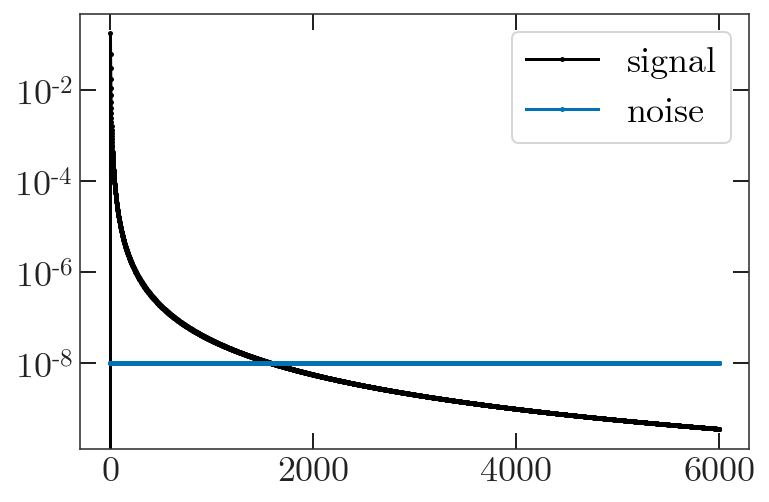

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8
plt.plot(ps, label="signal")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()

In [6]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask=mask)

Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([ 1.40248110e-04, -1.24482349e-05,  1.44619456e-05,  1.77871642e-07,
        3.38792649e-06,  1.45298657e-06,  1.01725645e-06,  4.69281677e-07,
        5.00556239e-07,  3.43586117e-07,  2.27828867e-07,  9.03778688e-08,
        1.55675112e-07,  1.25097465e-07,  4.58433047e-08,  5.98944306e-08,
        5.91860682e-08,  3.14159881e-08,  3.89526186e-08,  2.79695263e-08,
        2.85983647e-08,  3.06669429e-08,  2.18247359e-08,  1.83811074e-08,
        2.23151562e-08,  1.61670274e-08,  1.66956455e-08,  1.56843033e-08,
        1.19860746e-08,  1.07450704e-08,  1.23428925e-08,  1.06129325e-08,
        9.23374985e-09,  8.04596909e-09,  9.10963744e-09,  7.27747429e-09,
        8.96784047e-09,  6.28440338e-09,  6.42577663e-09,  7.34590671e-09,
        4.30947992e-09,  5.23430362e-09,  3.57958165e-09,  4.22751388e-09,
        3.47300266e-09,  3.20090577e-09,  1.86539657e-09,  1.62099613e-09,
        1.45401621e-09,  1.11516900e-09,  1.03702388e-09,  7.42367914e-10,
        3.41608198

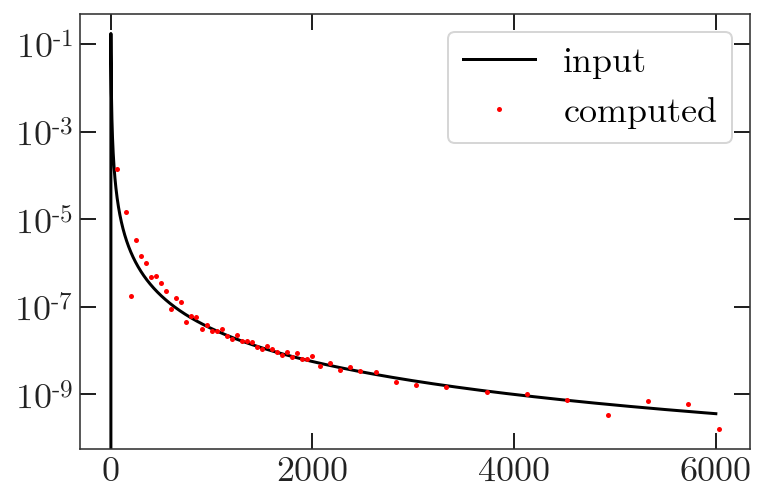

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')